In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d0f6e60819f9a5a.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccf708985967f09.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bdcc23296db1516.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9cb97f87870407f0.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9bf9cca507923334.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c077ad23a231abb.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6a6499354e3197.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9c3f1c10ba54ed56.jpg
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy/9d6acb154f9932c8.jpg
/kaggle/in

In [2]:
# Import fundamental libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import for pre-processing and data loading
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Import for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Import for file navigation
import os
import pathlib

print("Libraries imported!")
print("TensorFlow version:", tf.__version__)

2025-09-16 11:07:29.758669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758020850.023507      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758020850.118508      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported!
TensorFlow version: 2.18.0


In [5]:
# Define the root path to your dataset
data_dir = "/kaggle/input/plant-disease-recognition-dataset/"
data_dir = pathlib.Path(data_dir)

# Define paths to the specific subsets (with the double folder names)
train_dir = data_dir / 'Train' / 'Train'
val_dir = data_dir / 'Validation' / 'Validation'
test_dir = data_dir / 'Test' / 'Test'

# Check the number of images
train_count = len(list(train_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))

print(f"Training images: {train_count}")
print(f"Validation images: {val_count}") 
print(f"Test images: {test_count}")

# Define model parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

# Define class names manually since we know them
class_names = ['Healthy', 'Powdery', 'Rust']
print(f"Classes: {class_names}")

Training images: 1322
Validation images: 60
Test images: 150
Classes: ['Healthy', 'Powdery', 'Rust']


In [6]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Only rescaling for validation and test
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
print("Training Generator:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nValidation Generator:")
validation_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=16,  # Smaller batch for validation
    class_mode='categorical',
    shuffle=False
)

print("\nTest Generator:")
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Training Generator:
Found 1322 images belonging to 3 classes.

Validation Generator:
Found 60 images belonging to 3 classes.

Test Generator:
Found 150 images belonging to 3 classes.


In [7]:
# Load the pre-trained model without the top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model so its weights are not updated during training
base_model.trainable = False

# Build the new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# See the model architecture
model.summary()

I0000 00:00:1758021428.124329      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758021428.125084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 16,  # Note: using 16 here to match the validation batch size
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758021476.125374     125 service.cc:148] XLA service 0x7c6bf81112c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758021476.126554     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758021476.126576     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758021477.147092     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/41 ━━━━━━━━━━━━━━━━━━━━ 10:29 16s/step - accuracy: 0.2812 - loss: 1.4688

I0000 00:00:1758021481.950261     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4977 - loss: 1.0303 - val_accuracy: 0.8750 - val_loss: 0.4012
Epoch 2/15
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8125 - loss: 0.5392

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8125 - loss: 0.5392 - val_accuracy: 0.8750 - val_loss: 0.3816
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8880 - loss: 0.3173 - val_accuracy: 0.9583 - val_loss: 0.2132
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8750 - loss: 0.3203 - val_accuracy: 0.9583 - val_loss: 0.2157
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9080 - loss: 0.2598 - val_accuracy: 0.9583 - val_loss: 0.1949
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.9688 - loss: 0.2305 - val_accuracy: 0.9583 - val_loss: 0.1939
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9247 - loss: 0.2111 - val_accuracy: 0.9583 - val_loss: 0.1986
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 1.0000 - loss: 0.1098 - val_accuracy: 0.9583 - val_loss: 0.1991
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9453 - loss: 0.1781 - val_accuracy: 0.9583 - val_loss: 0.1

Evaluating on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9602 - loss: 0.1463

Test Accuracy: 96.67%


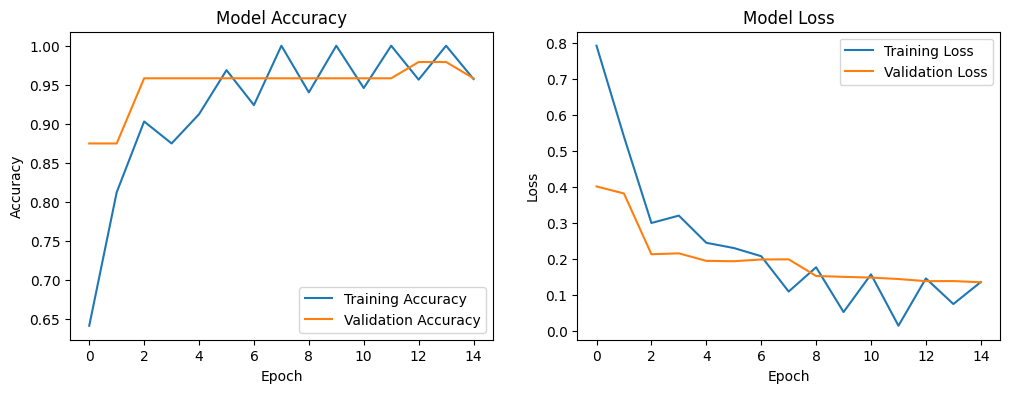

In [9]:
# Evaluate on the test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.96      0.95        50
     Powdery       0.96      0.96      0.96        50
        Rust       1.00      0.98      0.99        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



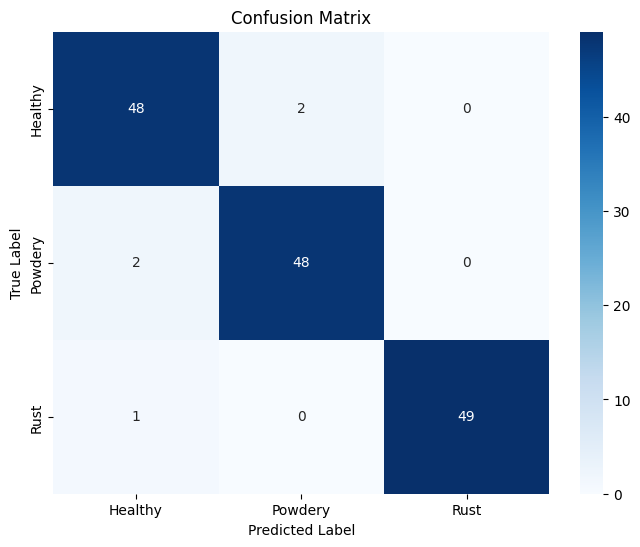

In [10]:
# Get true labels and predicted probabilities
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Generate a classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Generate and plot a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# Save your model in the preferred format
model.save('plant_disease_model.keras')
print("Model saved successfully as 'plant_disease_model.keras'")

# Also save in H5 format for compatibility
model.save('plant_disease_model.h5')
print("Model also saved as 'plant_disease_model.h5'")

# Let's verify the files were created
import os
print("\nFiles in current directory:")
for file in os.listdir('/kaggle/working'):
    if 'plant_disease' in file:
        print(f"✓ {file}")

Model saved successfully as 'plant_disease_model.keras'
Model also saved as 'plant_disease_model.h5'

Files in current directory:
✓ plant_disease_model.keras
✓ plant_disease_model.h5
